# Description:

This notebook contains several experiments with bokeh and hexagonal matrices in order to produce a suitable U-matrix and test the interactive components we want to include in the visualization.

In [1]:
from bokeh.colors import RGB
from bokeh.core.properties import AngleSpec
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file
from bokeh.util.hex import cartesian_to_axial
from matplotlib.pyplot import get_cmap

import os
import logging
import sompy
import numpy as np
import pandas as pd
from src.visualization.embedding_space import embedding_vectors, read_data
from src.cluster.som_clustering import UMatrix, main
from src import PROJECT_ROOT

# display bokeh plot in notebook
output_notebook()

'pattern' package not found; tag filters are not available for English


Loading BokehJS ...

In [2]:
data_file = os.path.join(PROJECT_ROOT, "data","processed", "newsapi_docs.csv")
model_dir = os.path.join(PROJECT_ROOT, "models", "saved_models")
fig_dir = os.path.join(PROJECT_ROOT, "models", "figures", "som")
model_path = os.path.join(PROJECT_ROOT, "models/saved_models/doc2vecdbowd100n5mc2t4.model")

In [3]:
logger = logging.getLogger(__name__)
model_tag = os.path.splitext(os.path.basename(model_path))[0]

logger.info('Reading data...')
# Reading data into memory
_, train_docs, test_docs = read_data(data_file)
train_labels = train_docs['category']

logger.info('Obtaining document embeddings...')
# Obtain the vectorized corpus
vect_train_corpus, _ = embedding_vectors(
    model_path, train_docs['prep_text'], test_docs['prep_text'])

# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

som = sompy.SOMFactory().build(
    vect_train_corpus,
    mapsize=(50, 50),
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
som.train(n_job=-1, verbose='info',
          train_rough_len=10, train_finetune_len=10)

Reading data...
Read data has a size of 5283Kb
Formatting data...
88052 documents from train set out of 110065 documents
Obtaining document embeddings...
loading Doc2Vec object from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model
{'uri': '/home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
loading vocabulary recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.vocabulary.* with mmap=None
loading trainables recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.trainables.* with mmap=None
loading wv recursively from /home/davids/GitHub/mapintel_project/models/saved_models/doc2vecdbowd100n5mc2t4.model.wv.* with mmap=None
loading docvecs recursively from /home/

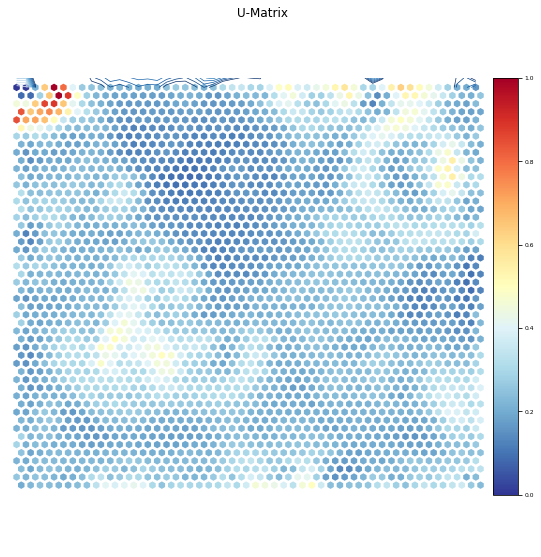

In [4]:
# Plot U-matrix using the UMatrix class
_, umat = UMatrix(
        width=12,
        height=12,
        text_size=6,
        title="U-Matrix",
        som=som,
        distance2=1,
        row_normalized=False,
        show_data=False,
        contoor=True
    ).show()

## U-matrix using Bokeh
### Challenges:

- Given a grid of size (x, y), place x\*y hexagons to form a hexagonal grid with odd-row offset:
    - locate the centers of each hexagon
    - figure out the right hexagon size
    - figure out the right offset value
    - ensure the grid is preserved when the image is changed (zoom, image size, screen size, etc)

Reference https://www.redblobgames.com/grids/hexagons/:
-  In the pointy orientation, a hexagon has width w = sqrt(3) * size and height h = 2 * size. The sqrt(3) comes from sin(60°).

In [5]:
# Builds the U-Matrix - each cell is the average distance of a given unit to its neighbors, where neighbors are units with distance less than self.distance2
# Reference: https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# The mapsize of the codebook (tuple)
msz = som.codebook.mapsize
# Same output as get_euclidean_coordinates
xx, yy = np.meshgrid(np.arange(msz[0]), np.arange(msz[1]))
xx, yy = xx.astype(float), yy.astype(float)
if som.codebook.lattice == 'hexa':  # apply odd-r hexagonal grid offset
    xx[::-2] -= 0.5
xx, yy = xx.T, yy.T
# Gets the BMU id for each data sample
proj = som.project_data(som.data_raw)
# Gets the x and y coordinates of each sample's BMU
xy = np.unravel_index(proj, msz)
coord = np.vstack((xx[xy], yy[xy])).T

In [6]:
# Plot Data
hex_centre_col, hex_centre_row = [], []
hex_color = []

# Define unique labels
categories = train_labels.unique()

# Iterate over grid position to compute hex centers and hex color
colormap = get_cmap('RdYlBu_r')
for i in range(msz[0]):
    for j in range(msz[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
        hex_centre_row.append(wy)
        hex_centre_col.append(xx[i, j])
        hex_color.append(colormap(umat[i, j]))

# Assign observations to each hex (the one corresponding to its BMU)
weight_x, weight_y = coord[:, 0], coord[:, 1] * 2 / np.sqrt(3) * 3 / 4
n_rows = weight_x.shape[0]
sample_size = 0.1
sample_ix = np.random.randint(0, n_rows, int(n_rows*sample_size))

# Convert matplotlib color palette to bokeh color palette
hex_plt = [(255 * np.array(i)).astype(int) for i in hex_color]
hex_bokeh = [RGB(*tuple(rgb)).to_hex() for rgb in hex_plt]

In [7]:
# # Single hexagons grid
# # initialise figure/plot
# fig = figure(title="SOM: Hexagonal Topology",
#              plot_height=800, plot_width=800,
#              match_aspect=True)

# # create data stream for plotting
# source_hex = ColumnDataSource(
#     data = dict(
#         x=hex_centre_row,
#         y=hex_centre_col,
#         c=hex_bokeh
#     )
# )

# source_pages = ColumnDataSource(
#     data=dict(
#         wx=weight_y[sample_ix],
#         wy=weight_x[sample_ix],
#         species=train_labels[sample_ix]
#     )
# )

# # define markers
# MARKERS = ['circle', 'diamond', 'cross', 'inverted_triangle', 'triangle', 'square', 'asterisk']

# # add shapes to plot
# fig.hex(x='y', y='x', source=source_hex,
#         size=30 * (.95 / np.sqrt(3)),
#         angle=30,  # pointy topped hexagon orientation
#         angle_units='deg',
#         line_color='gray',
#         fill_color='c')

# fig.scatter(x='wy', y='wx', source=source_pages, 
#             legend_field='species',
#             size=10,
#             alpha=0.2,
#             marker=factor_mark(field_name='species', markers=MARKERS, factors=categories),
#             color=factor_cmap(field_name='species', palette='Category10_7', factors=categories))

# # add hover-over tooltip
# fig.add_tools(HoverTool(
#     tooltips=[
#         ("label", '@species'),
# #         ("(x,y)", '($x, $y)')
#     ],
#     mode="mouse",
#     point_policy="follow_mouse"
# ))

# show(fig)

In [9]:
# Hexagonal tile grid
# initialise figure/plot
fig = figure(title="SOM: Hexagonal Topology",
             plot_height=800, plot_width=800,
             match_aspect=True)

# create data stream for plotting
scaling_factor = 1 / np.sqrt(3)  # I don't understand this. It works though
q, r = cartesian_to_axial(np.array(hex_centre_col), np.array(hex_centre_row), size=scaling_factor, orientation='pointytop')
wy, wx = weight_y / scaling_factor, weight_x / scaling_factor

source_hex = ColumnDataSource(
    data = dict(
        x=q,
        y=r,
        c=hex_bokeh
    )
)

source_pages = ColumnDataSource(
    data=dict(
        wx=wy[sample_ix],
        wy=wx[sample_ix],
        species=train_labels[sample_ix]
    )
)

# define markers
MARKERS = ['circle', 'diamond', 'cross', 'inverted_triangle', 'triangle', 'square', 'asterisk']

# add shapes to plot
fig.hex_tile(q='x', r='y', source=source_hex,
              line_color='gray',
              fill_color='c')

fig.scatter(x='wy', y='wx', source=source_pages, 
             legend_field='species',
             size=10,
             alpha=0.2,
             marker=factor_mark(field_name='species', markers=MARKERS, factors=categories),
             color=factor_cmap(field_name='species', palette='Category10_7', factors=categories))

# add hover-over tooltip
fig.add_tools(HoverTool(
    tooltips=[
        ("label", '@species'),
#         ("(x,y)", '($x, $y)')
    ],
    mode="mouse",
    point_policy="follow_mouse"
))

# figure options
fig.title.align = "center"
fig.title.text_font_size = "25px"
fig.grid.visible = False
fig.axis.visible = False

show(fig)